In [26]:
import polars as pl
import numpy as np
import pandas as pd
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OrdinalEncoder
from matplotlib import pyplot as plt

diretorio = "D:\dados - tcc mba/csv_files"

# Tratamento dos dados
- set_table_dtypes = Dados de colunas que terminam em 'P' ou 'A' são transformados em float64;
- convert_strings = Converte colunas de strings em um DataFrame pandas em colunas categóricas
- filter_cols = deleta colunas com mais de 50% dos dados nulos;


In [27]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df


def filter_cols(df):
    # Retira colunas que tenham mais de 70% de valores nulos
    cols_to_keep = ["target", "case_id", "WEEK_NUM", 'totalamount_6A', 'totalamount_996A', 'totaldebtoverduevalue_178A', 'totaldebtoverduevalue_718A', 'totaloutstanddebtvalue_39A', 'totaloutstanddebtvalue_668A']
    cols_to_drop = []
    
    for col in df.columns:
        if col not in cols_to_keep:
            isnull = df[col].isnull().mean()
            if isnull > 0.5:
                cols_to_drop.append(col)

    df = df.drop(columns=cols_to_drop, errors='ignore')

    # Vê a quantidade de valores únicos na coluna, se a coluna tiver exatamente um valor único ou mais de 200, essa coluna é excluída
    cols_to_drop = []
    for col in df.columns:
        if col not in cols_to_keep:
            unique_count = df[col].nunique()
            if unique_count == 1 or unique_count > 200:
                cols_to_drop.append(col)

    df = df.drop(columns=cols_to_drop, errors='ignore')

    return df




# Importação de dados do diretório
Precisa-se de um método e explicações para selecionar determinadas bases, visto que tenho recurso computacional limitado.

In [28]:
# ---------- Dados Treino

train_basetable = pl.read_csv(diretorio + "/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(diretorio + "/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(diretorio + "/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(diretorio + "/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(diretorio + "/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(diretorio + "/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes)

In [29]:
# ---------- Dados Teste

test_basetable = pl.read_csv(diretorio + "/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(diretorio + "/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(diretorio + "/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(diretorio + "/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(diretorio + "/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(diretorio + "/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(diretorio + "/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

# Agrupamento e organização dos dados
O depth vai de 0 a 2, sendo que zero é o conjunto de dados menos agrupados (mais granulares) e dois são os dados mais agrupados (menos granulares)


In [30]:
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed"))


# Pessoa que solicitou o empréstimo
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Agrupamento
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)


selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)


selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)


# Join
data_treino = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

data_treino.head()

case_id,date_decision,MONTH,WEEK_NUM,target,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,disbursedcredamount_1113A,downpmt_116A,inittransactionamount_650A,lastapprcommoditycat_1041M,lastapprcommoditytypec_5251766M,lastapprcredamount_781A,lastcancelreason_561M,lastotherinc_902A,lastotherlnsexpense_631A,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectreason_759M,lastrejectreasonclient_4145040M,maininc_215A,maxannuity_159A,maxannuity_4075009A,maxdebt4_972A,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,previouscontdistrict_112M,price_1097A,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A,mainoccupationinc_384A_max,mainoccupationinc_384A_any_selfemployed,person_housetype,pmts_pmtsoverdue_635A_max,pmts_dpdvalue_108P_over31
i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,str,f64,f64,str,str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,bool,str,f64,bool
0,"""2019-01-03""",201901,0,0,null,1917.6,0.0,null,null,null,null,30000.0,0.0,0.0,30000.0,0.0,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,10800.0,false,null,null,null
1,"""2019-01-03""",201901,0,0,null,3134.0,0.0,null,null,null,null,19999.8,0.0,0.0,19999.8,0.0,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,10000.0,false,null,null,null
2,"""2019-01-04""",201901,0,0,null,4937.0,0.0,null,null,null,null,78000.0,0.0,0.0,78000.0,0.0,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",10000.0,"""a55475b1""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,14000.0,false,null,null,null
3,"""2019-01-03""",201901,0,0,null,4643.6,0.0,null,null,null,null,40000.0,0.0,0.0,40000.0,0.0,null,"""a55475b1""","""a55475b1""",null,"""P94_109_143""",null,null,"""a55475b1""","""a55475b1""",59999.8,"""P94_109_143""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,10000.0,false,null,null,null
4,"""2019-01-04""",201901,0,1,null,3390.2,0.0,null,null,null,null,44000.0,0.0,0.0,44000.0,0.0,null,"""a55475b1""","""a55475b1""",null,"""P24_27_36""",null,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,24000.0,false,null,null,null


In [31]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_teste = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

data_teste.head()

case_id,date_decision,MONTH,WEEK_NUM,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,disbursedcredamount_1113A,downpmt_116A,inittransactionamount_650A,lastapprcommoditycat_1041M,lastapprcommoditytypec_5251766M,lastapprcredamount_781A,lastcancelreason_561M,lastotherinc_902A,lastotherlnsexpense_631A,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectreason_759M,lastrejectreasonclient_4145040M,maininc_215A,maxannuity_159A,maxannuity_4075009A,maxdebt4_972A,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,previouscontdistrict_112M,price_1097A,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A,mainoccupationinc_384A_max,mainoccupationinc_384A_any_selfemployed,person_housetype,pmts_pmtsoverdue_635A_max,pmts_dpdvalue_108P_over31
i64,str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,str,f64,f64,str,str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,bool,str,f64,bool
57543,"""2021-05-14""",202201,100,191767.36,3674.6,1218.2001,16049.4,17054.4,14554.4,24482.0,20000.0,12154.4,0.0,20000.0,0.0,null,"""a55475b1""","""a55475b1""",14000.0,"""a55475b1""",null,null,"""P109_133_183""","""P49_111_165""",24000.0,"""a55475b1""","""a55475b1""",34000.0,280983.56,null,231440.03,131700.8,16672.6,157731.78,16641.4,"""a55475b1""",0.0,12154.4,12154.4,12154.4,456031.1,17859.6,"""2fc785b2""","""6b2ae0fa""","""a55475b1""","""38c061ee""","""a55475b1""",null,null,null,null,34000.0,false,null,null,null
57549,"""2022-01-17""",202201,100,129704.4,5742.6,3546.6,32426.201,118964.805,13681.714,32426.201,75000.0,10638.2,10638.2,75000.0,0.0,null,"""a55475b1""","""a55475b1""",94000.0,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",160000.0,"""a55475b1""","""P30_86_84""",44000.0,337659.8,null,34066.0,122511.4,31820.6,21278.0,122511.4,"""a55475b1""",null,10638.2,10638.2,10638.2,373720.84,126058.0,"""2fc785b2""","""39a0853f""","""a55475b1""","""a7fcb6e5""","""a55475b1""",null,null,26815.6,null,49800.0,false,null,null,null
57551,"""2020-11-27""",202201,100,71036.4,2844.6,0.0,8357.2,null,0.0,9551.0,27095.201,0.0,0.0,27095.201,0.0,null,"""a55475b1""","""a55475b1""",200000.0,"""P85_114_140""",null,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""","""a55475b1""",70000.0,83400.0,null,54000.0,41783.402,54000.0,62619.0,null,"""P11_36_178""",27095.201,0.0,0.0,0.0,75219.0,null,"""2fc785b2""","""6b2ae0fa""","""a55475b1""","""3439d993""","""a55475b1""",null,null,null,null,59600.0,false,null,null,null
57552,"""2020-11-27""",202201,100,183992.0,6298.8003,12155.4,7440.4,null,199322.4,9148.4,100000.0,191269.61,191269.61,100000.0,0.0,null,"""a55475b1""","""a55475b1""",0.0,"""P94_109_143""",null,null,"""a55475b1""","""a55475b1""",150000.0,"""a55475b1""","""P94_109_143""",null,110500.0,null,188126.14,12155.4,104473.6,288642.6,12155.4,"""P21_87_50""",null,191269.61,191269.61,191269.61,284213.0,18889.0,"""2fc785b2""","""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,23402.8,null,112000.0,false,"""OWNED""",null,null
57569,"""2021-12-20""",202201,100,0.0,4682.6,0.0,null,null,null,10796.4,60000.0,0.0,0.0,60000.0,0.0,null,"""a55475b1""","""a55475b1""",20000.0,"""P94_109_143""",null,null,"""a55475b1""","""a55475b1""",40000.0,"""a55475b1""","""P94_109_143""",6000.0,37704.0,null,64555.668,null,null,0.0,null,"""a55475b1""",null,0.0,0.0,0.0,95348.42,null,"""2fc785b2""","""717ddd49""","""a55475b1""","""3439d993""","""a55475b1""",null,null,17333.6,null,58000.0,false,"""OWNED""",null,null


# Tratamento dos IDs, seleção de colunas, conversão polars para pandas

In [32]:
# Embaralha os IDs de casos únicos no conjunto de dados data_treino e divide esses IDs em treino, teste e validação
case_ids = data_treino["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

# Adiciona à lista cols_pred todas as colunas cujo último caractere é uma letra maiúscula e os caracteres anteriores são letras minúsculas.
cols_pred = []
for col in data_treino.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

# Polars para Pandas
def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data_treino.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data_treino.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data_treino.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, treino_x, treino_y = from_polars_to_pandas(case_ids_train)
base_valid, valid_x, valid_y = from_polars_to_pandas(case_ids_valid)
base_test, teste_x, teste_y = from_polars_to_pandas(case_ids_test)


for df in [treino_x, valid_x, teste_x]:
    df = convert_strings(df)

In [33]:
print(f"Train: {treino_x.shape}")
print(f"Valid: {valid_x.shape}")
print(f"Test: {teste_x.shape}")

Train: (915995, 48)
Valid: (305332, 48)
Test: (305332, 48)


# Retira colunas que tenham mais de 50% de valores nulos

In [34]:
treino_x = filter_cols(treino_x)
valid_x = filter_cols(valid_x)
teste_x = filter_cols(teste_x)

print(f"Train: {treino_x.shape}")
print(f"Valid: {valid_x.shape}")
print(f"Test: {teste_x.shape}")



Train: (915995, 12)
Valid: (305332, 12)
Test: (305332, 12)


# Análise fatorial para diminuir dimensionalidade das variáveis categóricas

In [35]:
# Selecionar colunas não numéricas
non_numeric_cols = treino_x.select_dtypes(exclude=['number']).columns

# Aplicar codificação one-hot
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Ajustar e transformar os dados de treino
treino_x_encoded = encoder.fit_transform(treino_x[non_numeric_cols])
valid_x_encoded = encoder.transform(valid_x[non_numeric_cols])
teste_x_encoded = encoder.transform(teste_x[non_numeric_cols])

# Converter os arrays de volta para DataFrames
treino_x_encoded_df = pd.DataFrame(treino_x_encoded, index=treino_x.index, columns=encoder.get_feature_names_out(non_numeric_cols))
valid_x_encoded_df = pd.DataFrame(valid_x_encoded, index=valid_x.index, columns=encoder.get_feature_names_out(non_numeric_cols))
teste_x_encoded_df = pd.DataFrame(teste_x_encoded, index=teste_x.index, columns=encoder.get_feature_names_out(non_numeric_cols))


# Definir o número de fatores
n_factors = 10  # Ajuste conforme necessário

# Aplicar a análise fatorial
fa = FactorAnalysis(n_components=n_factors, random_state=42)


# Ajustar e transformar os dados de treino
treino_x_factors = fa.fit_transform(treino_x_encoded_df)
valid_x_factors = fa.transform(valid_x_encoded_df)
teste_x_factors = fa.transform(teste_x_encoded_df)

# Converter de volta para DataFrames
treino_x_factors_df = pd.DataFrame(treino_x_factors, index=treino_x.index, columns=[f'Factor{i+1}' for i in range(n_factors)])
valid_x_factors_df = pd.DataFrame(valid_x_factors, index=valid_x.index, columns=[f'Factor{i+1}' for i in range(n_factors)])
teste_x_factors_df = pd.DataFrame(teste_x_factors, index=teste_x.index, columns=[f'Factor{i+1}' for i in range(n_factors)])

# Combinar fatores com as colunas numéricas originais
treino_x = treino_x.drop(columns=non_numeric_cols).join(treino_x_factors_df)
valid_x = valid_x.drop(columns=non_numeric_cols).join(valid_x_factors_df)
teste_x = teste_x.drop(columns=non_numeric_cols).join(teste_x_factors_df)



c:\Users\Computadores Gamer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Matriz de fatores

In [36]:
# Obter a matriz de cargas fatoriais
cargas_fatoriais = fa.components_.T

# Converter para DataFrame para facilitar a interpretação
cargas_fatoriais_df = pd.DataFrame(cargas_fatoriais, index=treino_x_encoded_df.columns, columns=[f'Fator{i+1}' for i in range(n_factors)])

# Definir um limite para cargas significativas
limite = 0.1

# Listar variáveis associadas a cada fator
variaveis_por_fator = {}
for i in cargas_fatoriais_df.columns:
    variaveis_por_fator[i] = cargas_fatoriais_df.index[cargas_fatoriais_df[i].abs() > limite].tolist()

# Mostrar variáveis por fator
for i, variaveis in variaveis_por_fator.items():
    print(f'{i}: {variaveis}')

Fator1: ['description_5085714M_2fc785b2', 'description_5085714M_a55475b1']
Fator2: ['description_5085714M_2fc785b2', 'description_5085714M_nan', 'education_1103M_nan', 'education_88M_a55475b1', 'education_88M_nan', 'maritalst_385M_nan', 'maritalst_893M_a55475b1', 'maritalst_893M_nan']
Fator3: []
Fator4: []
Fator5: ['lastcancelreason_561M_P94_109_143', 'lastcancelreason_561M_a55475b1', 'lastrejectcommoditycat_161M_a55475b1', 'lastrejectreason_759M_P94_109_143', 'lastrejectreason_759M_P99_56_166', 'lastrejectreason_759M_a55475b1', 'lastrejectreasonclient_4145040M_P94_109_143', 'lastrejectreasonclient_4145040M_a55475b1']
Fator6: ['education_1103M_a55475b1', 'maritalst_893M_a55475b1']
Fator7: []
Fator8: ['lastrejectreason_759M_P99_56_166', 'lastrejectreason_759M_a55475b1']
Fator9: ['education_1103M_6b2ae0fa', 'education_1103M_a55475b1', 'maritalst_385M_3439d993', 'maritalst_385M_a55475b1']
Fator10: []


In [37]:
del treino_x_encoded_df, valid_x_encoded_df, teste_x_encoded_df

# Rodando uma Random Forest como teste
Tentativa de grid_search para tunning do modelo, mas não foi possível devido ao recuso computacional limitado

In [38]:
rf = RandomForestClassifier(random_state=123)

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None]  # Remover 'auto' e usar valores válidos
# }

rf.fit(treino_x, treino_y)

RandomForestClassifier(random_state=123)

In [39]:
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')
# grid_search.fit(treino_x, treino_y)
# print("Melhores parâmetros encontrados:", grid_search.best_params_)
# print("Melhor pontuação ROC AUC:", grid_search.best_score_)


In [40]:
# best_rf = grid_search.best_estimator_
# y_pred_proba = best_rf.predict_proba(valid_x)[:, 1]
# auc_score = roc_auc_score(valid_y, y_pred_proba)
# auc_score

# Importância das features

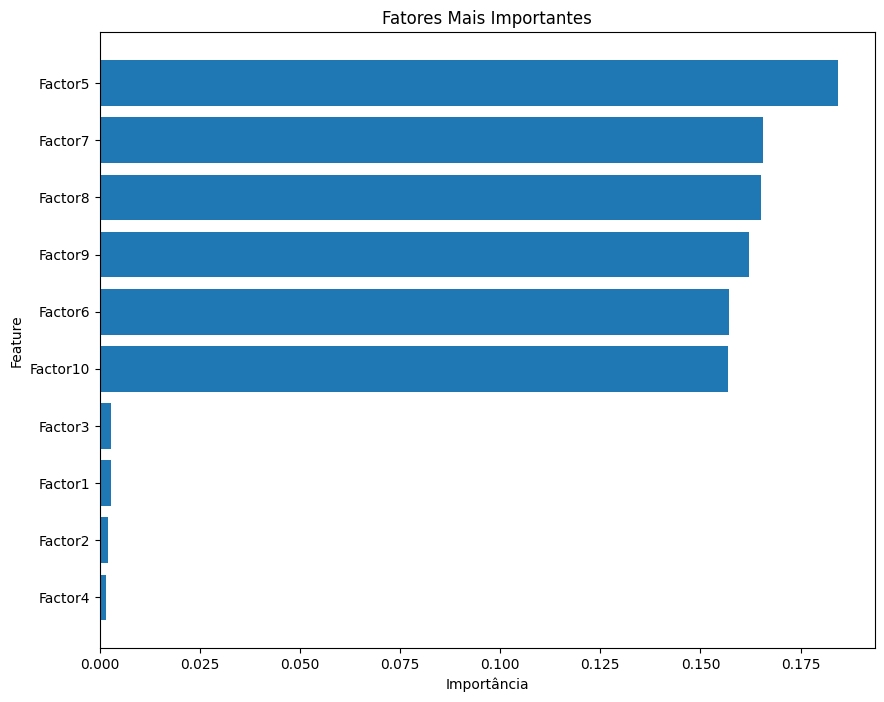

In [41]:
sort = rf.feature_importances_.argsort()
variaveis_top = sort[:]
variaveis_nome = treino_x.columns

plt.figure(figsize=(10, 8))
plt.barh(variaveis_nome[variaveis_top], rf.feature_importances_[variaveis_top])
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.title("Fatores Mais Importantes")
plt.show()



# Random Forest usando fatores como features

In [42]:
rf2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf2.fit (treino_x_factors_df, treino_y)

RandomForestClassifier(random_state=42)

# Matriz de confusão

Acurácia do modelo com fatores: 0.9684
Acurácia no conjunto de teste: 0.9676


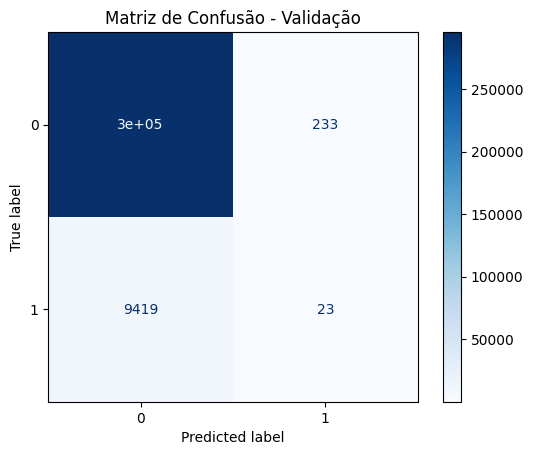

In [43]:
# Previsões no conjunto de validação
valid_predictions = rf2.predict(valid_x_factors_df)

# Avaliação do desempenho do modelo
accuracy = accuracy_score(valid_y, valid_predictions)
print(f"Acurácia do modelo com fatores: {accuracy:.4f}")

# Previsões no conjunto de teste
teste_predictions = rf2.predict(teste_x_factors_df)
teste_accuracy = accuracy_score(teste_y, teste_predictions)
print(f"Acurácia no conjunto de teste: {teste_accuracy:.4f}")


# Gerar a matriz de confusão
mc = confusion_matrix(valid_y, valid_predictions)

# Exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=mc, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Validação")
plt.show()

# F1-score e ROC-AUC

In [44]:
# F1 Score
f1 = f1_score(valid_y, valid_predictions, average='weighted')
print(f"F1 Score no conjunto de validação: {f1:.4f}")

# ROC-AUC
if len(np.unique(treino_y)) == 2:  # Checa se é um problema binário
    roc_auc = roc_auc_score(valid_y, rf2.predict_proba(valid_x_factors_df)[:, 1])
    print(f"ROC-AUC no conjunto de validação: {roc_auc:.4f}")

F1 Score no conjunto de validação: 0.9537
ROC-AUC no conjunto de validação: 0.6169
